#  <span style="color:blue">Tutorial - Planning and Control</span>

The following tutorial tasks implement concepts covered in these notes using Python:
- Trajectory planning from waypoints
- State-space control
- Simulation including motion models

<img src="images/A1_4_Tutorial_Overview.png" alt="Tutorial Overview" width="800px" align="center"/>

Classes and functions used in this section are also contained in the course libraries `model_feeg6043.py` and `math_feeg6043.py` and `plot_feeg6043.py` libraries. Here we will learn to use the course class library `TrajectoryGenerate` in `model_feeg6043.py`, which implements the theory covered on trajectory generation. The figure below gives an overview of what we will cover.

In [2]:
import numpy as np

from matplotlib import pyplot as plt
from math_feeg6043 import Vector,Matrix,Identity,Transpose,Inverse,v2t,t2v,HomogeneousTransformation, l2m
from plot_feeg6043 import plot_zero_order,plot_trajectory,plot_2dframe
from model_feeg6043 import TrajectoryGenerate

help(TrajectoryGenerate)

Help on class TrajectoryGenerate in module model_feeg6043:

class TrajectoryGenerate(builtins.object)
 |  TrajectoryGenerate(x_path, y_path)
 |  
 |  Class to generate trajectories from a path of x,y, coordinates defined in the earth fixed frame
 |  This path can be used as input for mobile robot control. 
 |  
 |  It key functions are to 
 |  - Assign timestamps, headings and linear and angular velocities to waypoints by implementing v-a couple trapezoidal trajectories between points
 |  - Generate turning arcs of a defined radius 
 |  - Sample the trajectory and associated model commands for any given timestamp
 |  - Manage waypoint progress considering waypoint acceptance radius and timeouts between consecutive waypoints
 |  
 |  Parameters:
 |  -----------
 |  x_path: List of Floats[]
 |      A sequence of x-axis (Northings) coordinates in the earth fixed frame in metres
 |  y_path: List of Floats[]
 |      A sequence of y-axis (Eastings) coordinates in the earth fixed frame in met

## <span style="color:Red">1. Planning</span>

### <span style="color:Red">Building Trajectories</span>

We can generate smooth velocity trajectories between points using the TragectoryGenerate class, which implements **v-a couple** for smooth, continuous, differentiable trajectories between two points that start at stop at the first and last waypoints points using the class function `self.path_to_trajectory(v, a)`

>    self.path_to_trajectory(v, a):
>
>        Takes the x_path and y_path parameters and generates trajectories by implementing v-a coupled trapezoidal trajectories between point pairs.
>        It assumes the first path entry starts from stationary, and that the last path entry ends at stationary. It populates the class attributes:
>        
>        P, Tp, V, W, D 
>        
>        and uses the class internal functions _point_to_point() and _stack_trajectory() to do this.        
>
>        Input:
>            v:  Float
>                Linear forwards velocity in m/s (body frame, b) to reach during coasting phases once accelerated and before decceleration
>            a:  Float                
>                Linear forwards acceleration in m/s2 (body frame, b) to apply during acceleration and decceleration phases

This implements the constraints

| <div style="width: 150px"> Method</div> | <div style="width: 150px">Constraint</div>  | <div style="width: 150px">Velocity, $\mathbf{v}$</div> | <div style="width: 150px">Acceleration, $\mathbf{a}$</div> | <div style="width: 150px">Total time, $\tau$</div> |
|:---------:|:-----------:|:---------:|:---------:|:---------:|
| **v-a couple** | $\mathbf{v}^2/\mathbf{a}\leq1$ | $\mathbf{v}$ | $\mathbf{a}$ | <span style="color:blue">$\dfrac{s}{\mathbf{v}}+\dfrac{\mathbf{v}}{\mathbf{a}}$</span>|

First test it for simple trajectory between path end points:
> $x_{path} = [0, 1]$\
> $y_{path} = [0, 0]$

Then for something involving a turn
> $x_{path} = [0, 1, 1]$\
> $y_{path} = [0, 0, 1]$

for 
> $v = 0.1$ m/s and $a = 0.1/3$m/s$^2$

[[0. 0.]
 [1. 0.]]
The trajectory has waypoint expected timestamps: s.Tp: [[0.        ]
 [0.00666667]
 [5.        ]
 [5.00666667]]
The trajectory has poses: s.P: [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.66666667e-04 0.00000000e+00 0.00000000e+00]
 [9.99333333e-01 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]]
The trajectory has velocities: s.V: [[0. ]
 [0.2]
 [0.2]
 [0. ]]
The trajectory has angular velocities: s.W: [[0.]
 [0.]
 [0.]
 [0.]]
The trajectory has segment distances: s.D: [[0.00000000e+00]
 [6.66666667e-04]
 [9.98666667e-01]
 [6.66666667e-04]]


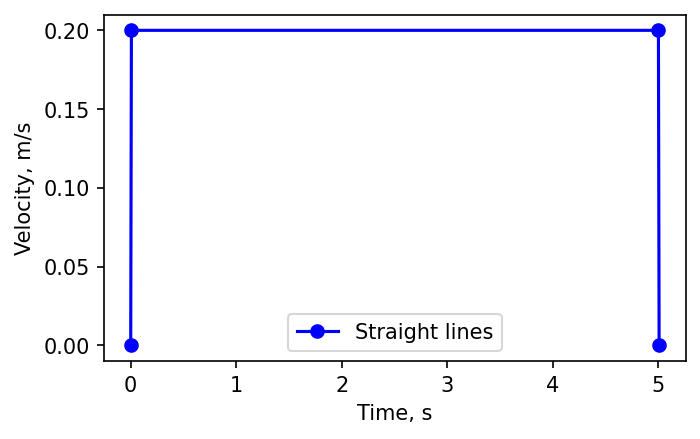

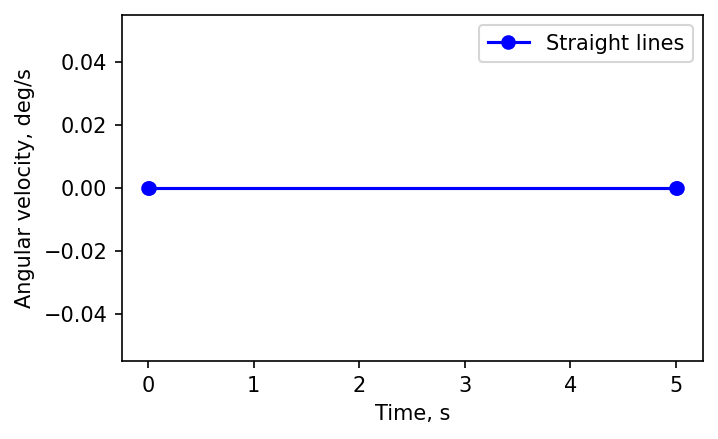

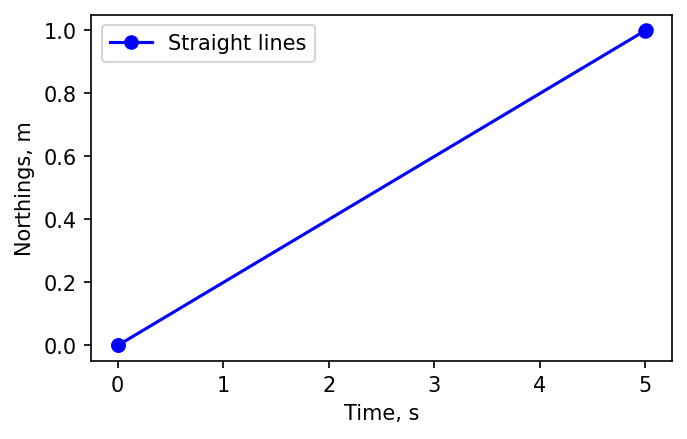

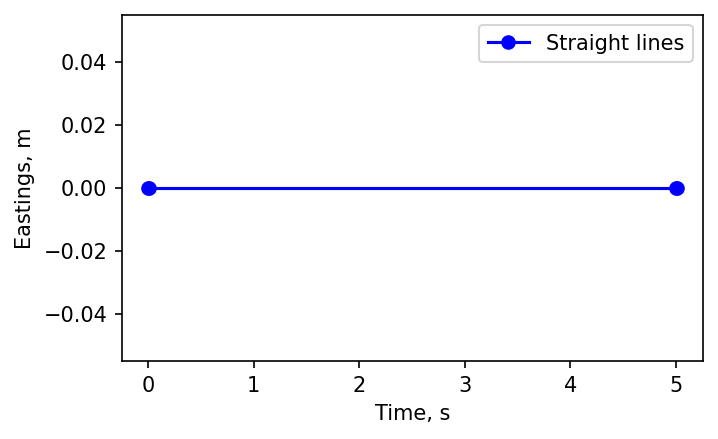

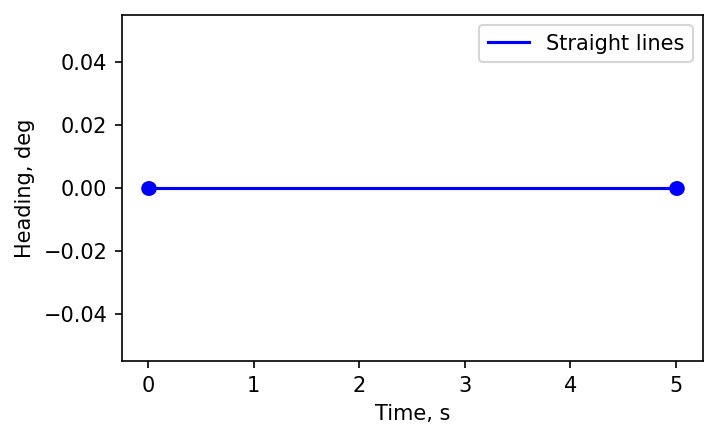

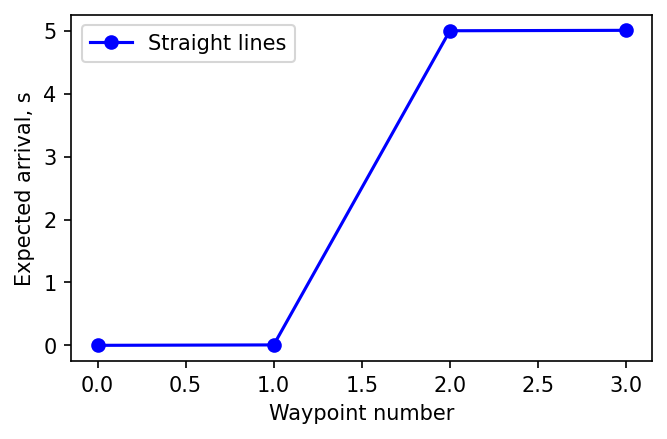

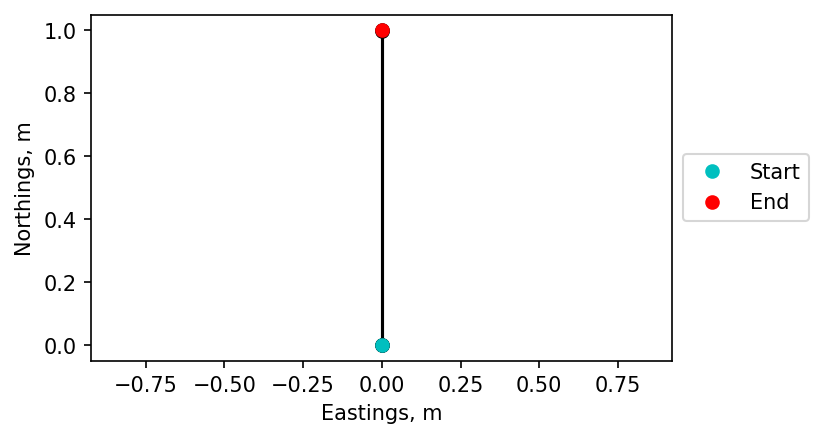

In [11]:
# define a path consisting of two points
x_path = [0, 1]
y_path = [0, 0]
C = l2m([x_path,y_path])

# create a class instance
s = TrajectoryGenerate(C[:,0],C[:,1])
print(C)
# set velocity and acceleration constraints
v = 0.2 #m/s
a = 3/0.1 #takes 3s to get to 0.1m/s
s.path_to_trajectory(v, a)

# show and plot the trajectory class
print('The trajectory has waypoint expected timestamps: s.Tp:',s.Tp)
print('The trajectory has poses: s.P:',s.P)
print('The trajectory has velocities: s.V:',s.V)
print('The trajectory has angular velocities: s.W:',s.W)
print('The trajectory has segment distances: s.D:',s.D)

plot_trajectory(s)

### <span style="color:red">Generating turning arcs</span>
The trajectory generated cannot be followed with constant velocity as it requires an instant heading change. Implement turning arcs with the class function `turning_arcs(radius)` to address this.

>    turning_arcs(radius):
>
>        A function that generates turning arcs of specified radius between staightline sections with different heading angles. It populates the class attibutes:
>        
>        P_arc, Tp_arc, V_arc, W_arc, D_arc, Arc, turning_radius
>        
>        and uses geometric operations implemented in math_feeg6043 inward_unit_norm() and line_intersection() to do this.
>        
>        Input:
>            radius:  Float
>                Radius in metres of turning arcs

Check that the timestamps, distances and directions of rotation make sense based on w=v/r. Compare the turning_arcs trajectory to the straight line trajectory for
> $x_{path} = [0, 1, 1], y_{path} = [0, 0, 1]$
>
> and
>
> $v = 0.1$ m/s, $a = 0.1/3$m/s$^2$ and  $r =0.5$ m 

c:\Users\skyem\OneDrive - University of Southampton\Uni\Intelligent Mobile Robotics\FEEG6043-Group\src\Tutorials\math_feeg6043.py:205: RuntimeWarning: invalid value encountered in divide
  unit_vector1 = vector1/distance1


Turning arcs cannot fit along line section. Increase angle between line section or reduce turning arc radius.
Total elapse time for turning arcs trajectory is: 88.69911184307752 s
Total distance for turning arcs trajectory is: 10.56991118430775 m
Total elapse time for straight line trajectory is: 99.0 s
Total distance for straight line trajectory is: 9.6 m
The trajectory has waypoint expected timestamps with turning arcs: s.Tp_arc: [[ 0.        ]
 [ 3.        ]
 [11.5       ]
 [17.78318531]
 [23.78318531]
 [30.06637061]
 [36.06637061]
 [42.34955592]
 [52.34955592]
 [52.34955592]
 [58.34955592]
 [64.63274123]
 [66.63274123]
 [72.91592654]
 [74.91592654]
 [81.19911184]
 [85.69911184]
 [88.69911184]]
The trajectory has poses with turning arcs: s.P_arc: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.50000000e-01  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -1.11022302e-16  0.00000000e+00]
 [ 1.40000000e+00  4.00000000e-01  1.57079633e+00]
 [ 1.40000000e+00  1.00000000e+00  1

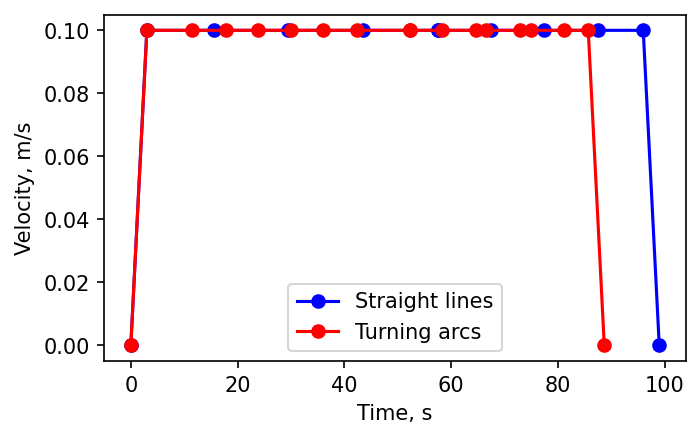

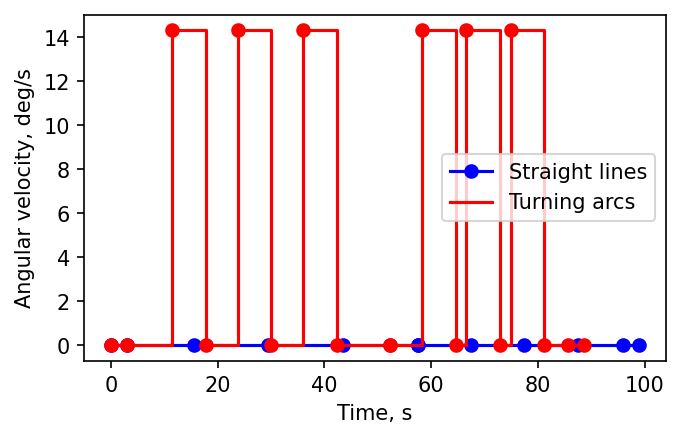

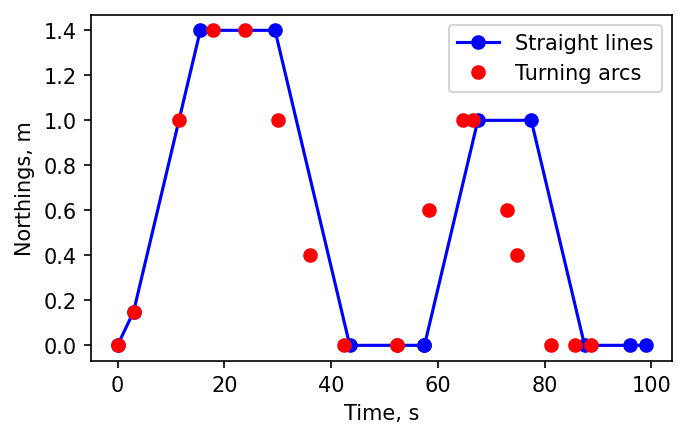

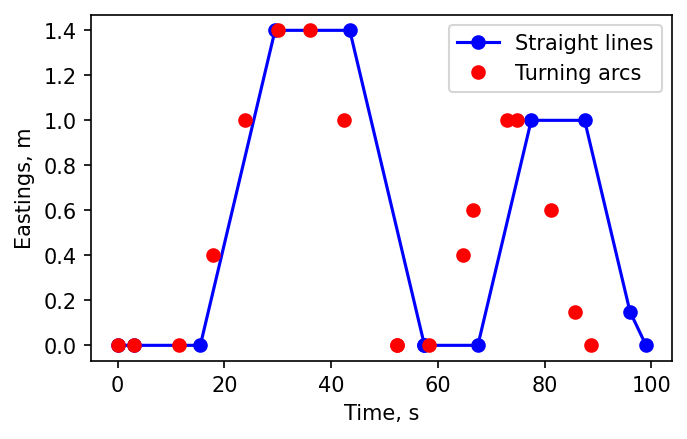

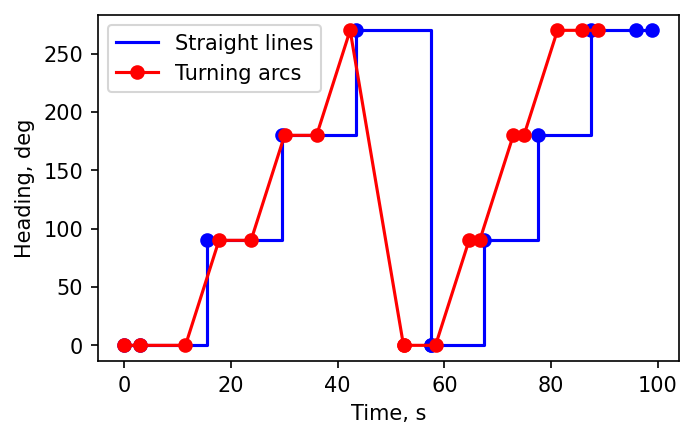

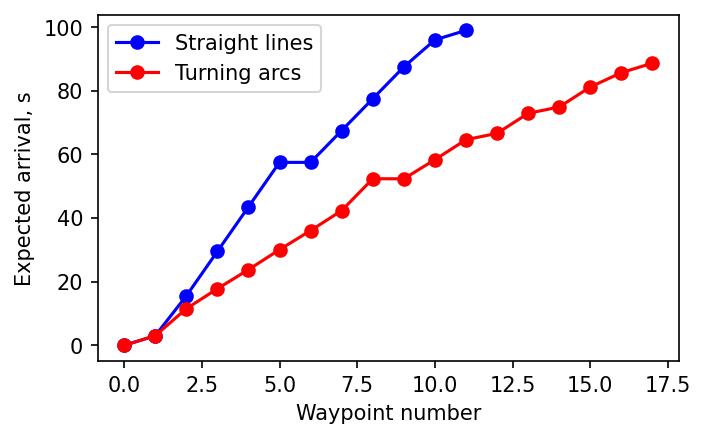

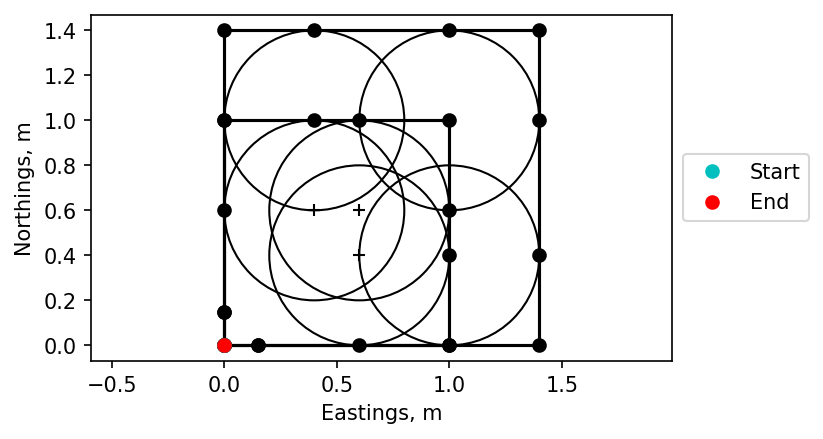

In [3]:

x_path = [0,1.4,1.4,0,0,0,1,1,0,0]
y_path = [0,0,1.4,1.4,0,0,0,1,1,0]     

# create a class instance
s = TrajectoryGenerate(x_path,y_path)

# set velocity and acceleration constraints
v = 0.1 #m/s
a = 0.1/3 #takes 3s to get to 0.1m/s
s.path_to_trajectory(v, a)

# generate turning arcs for a specified radius
radius = 0.4 #m
s.turning_arcs(radius)

# Print the outputs
print('Total elapse time for turning arcs trajectory is:',s.Tp_arc[-1,0],'s')
print('Total distance for turning arcs trajectory is:',sum(s.D_arc[:,0]),'m')
print('Total elapse time for straight line trajectory is:',s.Tp[-1,0],'s')
print('Total distance for straight line trajectory is:',sum(s.D[:,0]),'m')

# show and plot the outputs
print('The trajectory has waypoint expected timestamps with turning arcs: s.Tp_arc:',s.Tp_arc)
print('The trajectory has poses with turning arcs: s.P_arc:',s.P_arc)
print('The trajectory has velocities with turning arcs: s.V_arc:',s.V_arc)
print('The trajectory has angular velocities with turning arcs: s.W_arc:',s.W_arc)
print('The trajectory has segment distances with turning arcs: s.D_arc:',s.D_arc)
print('The trajectory has turning arcs radius: s.Arc:',s.Arc)
plot_trajectory(s, arc_radius = radius)
plt.show()

### <span style="color:red">Sampling for control</span> 
 
At any moment, a controller needs to have a reference pose. This can be sampled from the planned trajectory using the `p_u_sample(t)` class function:

>    p_u_sample(t):
>
>        A function that samples P_arc, Tp_arc, V_arc, W_arc, D_arc, Arc, turning_radius at time t, where the outputs can be used as inputs for control. 
>        It uses geometric operations implemented in math_feeg6043 short_angle() amd interpolate() to do this
>        
>        Input:
>            t: Float
>                Timestamp in seconds to sample the trajectory at
>        
>        Output:
>            p: Vector(3)
>                Pose is a [3 x 1] matrix of the form
>                  [[x]      Northings in m in the earth fixed frame, e
>                   [y]      Eastings in m in the earth fixed frame, e
>                   [gamma]] Heading in radians about the downwards axis in the earth fixed frame, e
>                   
>            u: Vector(2)            
>                Body twist is a [2 x 1] matrix of the form
>                  [[v]      Linear forwards velocity in m/s (body frame, b)
>                   [w]]     Angular velocity in rads/s (body frame, b)

We will sample the trajectory we just generated at different times to make sure we understand its behaviour. Set the next wp id as the last waypoint for now as we will cover waypoint acceptance later. 
- Confirm it follows the turning arc as expected with correct angular velocities (w=v/r)
- Confirm the behaviour when it ends the mission
- Check different paths and turning radius to understand behaviour

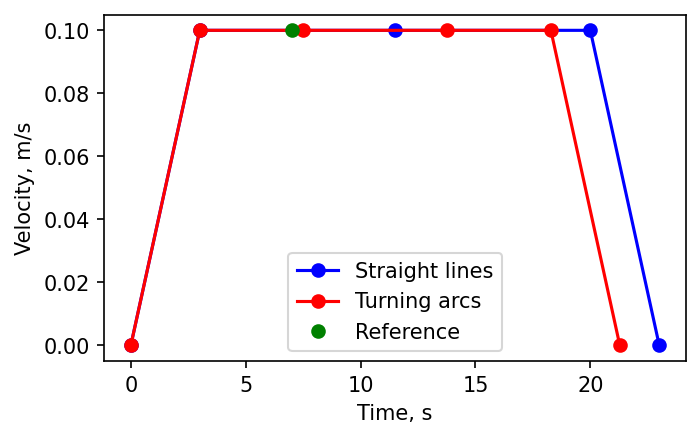

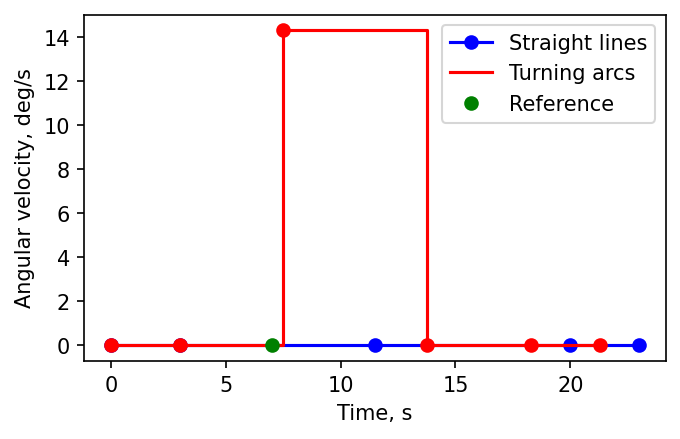

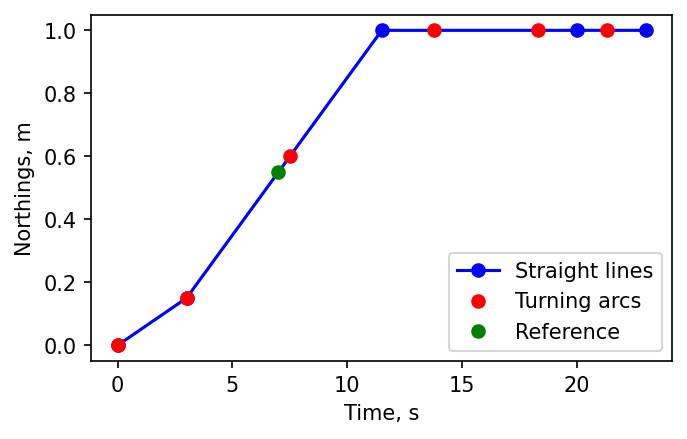

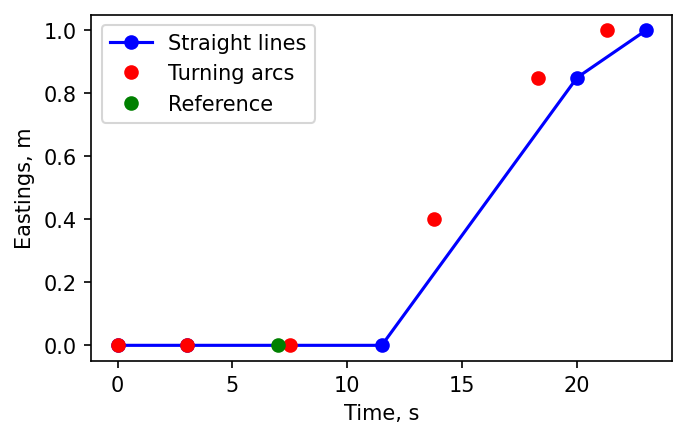

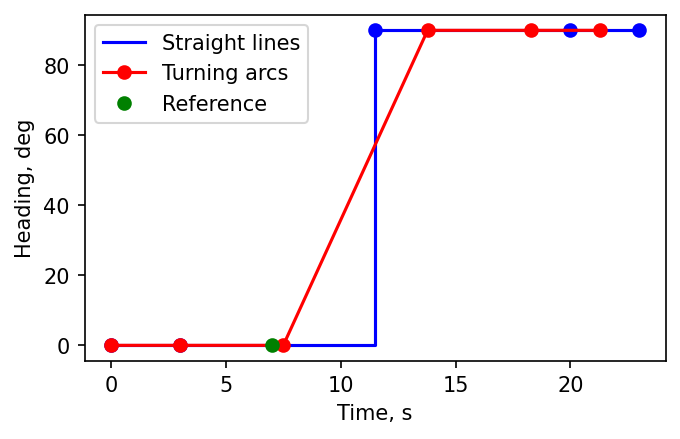

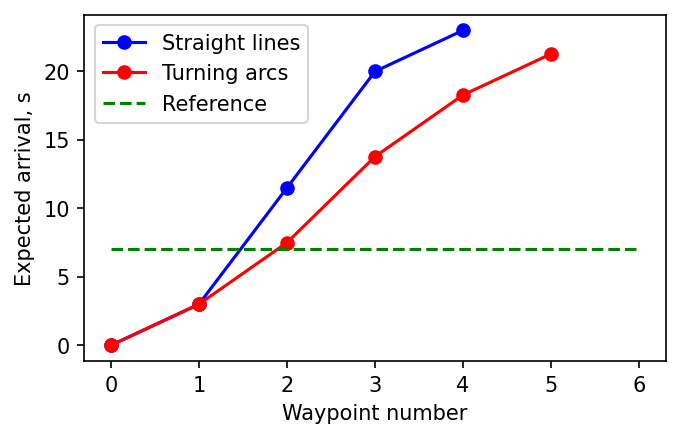

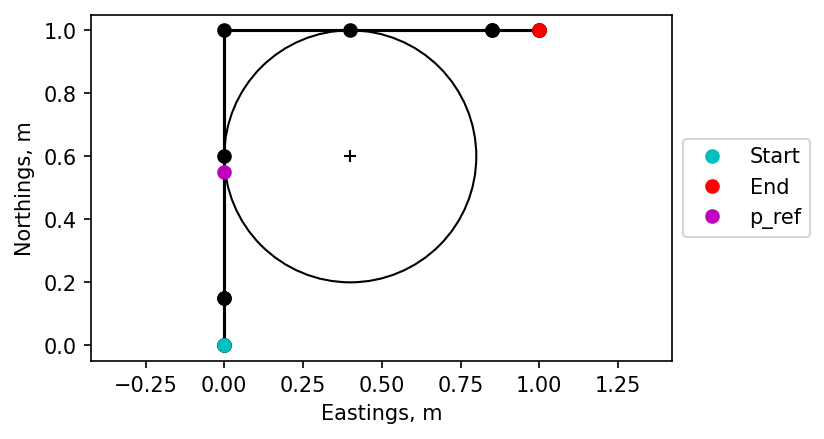

Reference control u_ref: v_ref [0.1] m/s, and w_ref [0.] deg/s


In [9]:
# temporarily set wp to maximum to understand trajectory sampling alone
s.wp_id = len(s.Tp_arc)

t=7
p_ref, u_ref = s.p_u_sample(t)

# function to plot trajectories, we can show the sample location
plot_trajectory(s,arc_radius = radius, t_ref = t, p_ref = p_ref, u_ref = u_ref)
plt.show()

print('Reference control u_ref: v_ref',u_ref[0],'m/s, and w_ref',np.rad2deg(u_ref[1]),'deg/s')

### <span style="color:red">Waypoint acceptance</span> 

To prevent trajectory sampling from leaving the robot far behind, it should pause at each waypoint until one of the following conditions is met:

- Proximity: The robot approaches within some acceptance radius
- Timeout: The delay is longer than a timeout criteria (e.g., 2x expected segment time is a common default setting)

Delays to expected arrival need to be used to increase expected time of future waypoints.

Use the class function `wp_progress()` to implement this:

>    wp_progress(t_robot, p_robot, accept_radius, timeout_factor = 2, initial_timeout = 30):
>
>        A function checks whether the trajectory sampled by p_u_sample can progress beyond the next waypoint in P_arc. 
>        It implements two conditions to allow this, the first is proximity, which progresses to the next waypoint if the distance between the robot and the waypoint is less than the acceptance radius
>        The second is a segment timeout, where waypoint will be progressed if the time takes to reach it is double the expected time. The function logs any delay to expected arrival at each waypoint to update future trajectory timestamps
>        For the initial waypoint as timeout of 10s is set in the code. The function modifies the class attributes
>        
>        Tp_arc, wp_id
>        
>        Input:
>            t_robot: Float 
>                Timestamp in seconds corresponding to the robot pose
>            p_robot: Vector(3)
>                Pose of the robot is a [3 x 1] matrix of the form
>                  [[x]      Northings in m in the earth fixed frame, e
>                   [y]      Eastings in m in the earth fixed frame, e
>                   [gamma]] Heading in radians about the downwards axis in the earth fixed frame, e            
>            accept_radius: Float
>                Acceptance radius in m for the next waypoint to be judged as passed

Repeat the earlier task but don't set wp_id to the end of the mission at the start. Set the waypoint acceptance radius to
>$ r_{accept} = 0.2$m

Try and triggor a few wp_id acceptance with both the robot pose and timeout criteria to make sure you understand how it behaves:
- Set wp_id = 3 as the next waypoint and change the robot pose to meet the acceptance criteria
- Set wp_id = 3 as the next waypoint and increase the time without meeting the acceptance criteria to trigger a time out (double the expected time taken to arrive from previous waypoint

**Check your understanding on the following points:**
- When did the waypoint timeout?Can you explain why this is the case? How did it affect the trajectory waypoint times?
- What happens to the trajectory waypoint times if you arrive at the point with a short delay (insufficient to trigger a timeout)?

In [ ]:
# reset the trajectory
s = TrajectoryGenerate(x_path,y_path)
s.path_to_trajectory(v, a)
s.turning_arcs(radius)

# Define the robot pose
p_robot = Vector(3)
p_robot[0] = 0.8
p_robot[1] = 0.4

# set a sample time (now for the robot)
t_robot = 8
# define a waypoint acceptance criteria
accept_radius = 4 #m
s.wp_id = 3

print('Trajectory wp timestamps\n',s.Tp_arc,'s')

# progress the waypoint and sample the trajectory
s.wp_progress(t_robot, p_robot, accept_radius)
p_ref, u_ref = s.p_u_sample(t_robot)

print('Updated trajectory wp timestamps\n',s.Tp_arc,'s')
print('Next waypoint is \n',s.wp_id)
plot_trajectory(s,arc_radius = radius, t_ref = t_robot, p_ref =  p_ref, p_robot = p_robot, accept_radius = accept_radius, show_time_history = False)
plt.show()

## <span style="color:Green">2. State space control</span>

State feedback modifies the control input prescribed by the reference trajectory by the feedback component:

\begin{eqnarray}
\Delta \mathbf{u}_k &=& K\Delta \mathbf{s}_k\notag\\
\begin{bmatrix}
\Delta v_k\\
\Delta \omega_k
\end{bmatrix}&=& 
\begin{bmatrix}
k_s & 0 & 0\\
0 & k_n & k_\gamma
\end{bmatrix} 
\begin{bmatrix}
\Delta s_k\\
\Delta n_k\\
\Delta \gamma_k
\end{bmatrix} &=& \begin{bmatrix}
k_s \Delta s_k\\
k_n \Delta n_k + k_\gamma \Delta \gamma_k
\end{bmatrix}
\end{eqnarray}

as $\mathbf{u}=\mathbf{u}_{ref}+\Delta \mathbf{u}$. First define the feedback_control law and set a simple straightline trajectory.

In [ ]:
def feedback_control(ds, ks = None, kn = None, kg = None):
    
    if ks == None: ks = 0.1
    if kn == None: kn = 0.1
    if kg == None: kg = 0.1        
    
    dv = ks*ds[0]                
    dw = (kn*ds[1]+kg*ds[2])
    
    du = Vector(2)
    du[0] = dv
    du[1] = dw
    
    return du

ds = [?,?,?]
print('du is',feedback_control(ds),'m/s and rad/s')

State space control takes the difference between the reference pose and the robot pose as seen from the body frame $b$ and modifies the sampled contol input ($v,w$). It is important to note the dependency of gain parameters on velocity, in particular if the robots moves with negative linear velocity.


The input to the feedback control is $\Delta \mathbf{s}$ relates $\Delta \mathbf{x}$ (difference in the environment frame $e$) through the homogeneous rotation matrix $\mathbf{H}_{eb}$, i.e., $\text{Rot}(\gamma)$ as:

> $$\Delta \mathbf{x}  = \text{Rot}(\gamma)\Delta \mathbf{s}$$

where we need the inverse relationship (i.e., rotation of $\mathbf{H}^{-1}_{eb}=\mathbf{H}_{be} =\text{Rot}(-\gamma)$:

> $$\Delta \mathbf{s}  = \text{Rot}(-\gamma)\Delta \mathbf{x}$$

The cell below implements the control for a simple reference trajectory sampled at different times.

Implement this below and sanity check the results. Investigate the response of the controller for:
- Change the time value so the trajectory is sampled at different times. What happens to the feed forward and feedback terms?
- Change the robot pose, try it at the reference value as well. . What happens to the feed forward and feedback terms?

In [ ]:
#################################################################
# Define simple trajectory
#################################################################
x_path = [3,3]
y_path = [1,3]
v = 0.1 #m/s
a = 0.1/3 #takes 3s to get to 0.1m/s
accept_radius = 0.1 #m

# establish the trajectory
s = TrajectoryGenerate(x_path,y_path)
s.path_to_trajectory(v, a)

#################################################################
# Main code from here
#################################################################
import copy

# set the t and the robot pose
t =5#s
p_robot = Vector(3); p_robot[0] = 0.5; p_robot[1] = 0.5; p_robot[2] = np.deg2rad(0) 

#################################################################
# feedforward control: sample the reference trajectory for now we don't want the sampling to stop at any waypoints
#################################################################
s.wp_id = len(s.Tp)
p_ref, u_ref = s.p_u_sample(t)

#################################################################
# feedback control: compute the difference to the reference as seen from the body frame
#################################################################
dp = p_ref-p_robot; dp[2] = (dp[2] + np.pi) % (2 * np.pi) - np.pi # checks for angle wrapping
H_eb = ?
ds=?

du = feedback_control(ds)

#################################################################
# Total control
#################################################################
u=?

#################################################################
# Show results
#################################################################
print('ds',ds[0],'dn',ds[1],'dg',ds[2])
print('Feedforward control dv=',u_ref[0],'m/s, dw=',np.rad2deg(u_ref[1]),'deg/s')    
print('Feeback control dv=',du[0],'m/s, dw=',np.rad2deg(du[1]),'deg/s')  
print('Total control dv=',u[0],'m/s, dw=',np.rad2deg(u[1]),'deg/s')  

# Homogeneous transformation for the reference pose and robot pose
H_es = HomogeneousTransformation(p_ref[0:2],p_ref[2])

# visualise the reference and robot poses
plot_trajectory(s,t_ref = t, p_ref =  p_ref, p_robot = p_robot, show_time_history = False)
cf=plot_2dframe(['pose','b'],[H_eb.H])
plt.show()

Make things dynamic and try things with the following gain parameters and then try with 5x each number to confirm the effects

```python
control parameters
tau_s = 5 #s to remove along track error
L = 1 #m distance to remove normal and angular error
```

```python
control parameters
tau_s = 1 #s to remove along track error
L = 0.2 #m distance to remove normal and angular error
```

The following physical parameters can guide gain tuning:

|  <div style="width: 150px"> Gain</div> | <div style="width: 150px">Value</div>  | <div style="width: 150px">$\Delta s\rightarrow 0$ </div> |<div style="width: 150px">$\Delta n\rightarrow 0$</div>  |<div style="width: 150px">$\Delta \omega\rightarrow 0$ </div> |
|:---------:|:-----------:|:---------:|:---------:|:---------:|
| $k_s$|   $1/\tau_s$      | $\tau_s$ (s) | - | - |
| $k_n$|   $2v/L^2$        |     -      | $L$ (m)   | $L$ (m)  |
| $k_\gamma$ | $v/L$       |     -      | $L$ (m)   | $L$ (m)  |

**Task 1:** Once you've done this, try it for a linear trajectory with a turn!
> x_path = [0,0,-2,]
>
> y_path = [0,2,2]

**Task 2:** Introduce turning arcs of radius 0.3m by adding the following in the right place
>  arc_radius = 0.3
>
> s.turning_arcs(arc_radius)

In [ ]:
from model_feeg6043 import rigid_body_kinematics

###################################################################
# Create some timestamps to simulate between and keyframes to show
###################################################################
start = 0
end = 200
timestep = 0.1 #s
num_points = int( end / timestep )+1
t_list = np.linspace(start, end, num_points)
t_prev=t_list[0]
#################################################################
# Setup control parameters
#################################################################
tau_s = ? #s to remove along track error
L = ? #m distance to remove normal and angular error
ks =  ?
#kn and kg depend on velocity so need to adapt dynamically
v_max = 0.2 #fastest the robot can go
w_max = np.deg2rad(30) #fastest the robot can turn
# setup a contranor to store controls
u = Vector(2)
U = u.T
#################################################################
# Setup trajectory sampling parameters
#################################################################
x_path = [?,?] #task 1
y_path = [?,?]

v = 0.1 #m/s
a = 0.1/3 #takes 3s to get to 0.1m/s
accept_radius = 0.2 #m

s = TrajectoryGenerate(x_path,y_path)
s.path_to_trajectory(v, a)
s.wp_id = 0 # reset waypoint counter
s.t_complete = np.nan # will log when the trajectory was complete 

# Generate turning arcs trajectory if needed
#################################################################
# Main simulation loop
#################################################################
# initialise robot pose and log a copy for visualisation later
p_robot = Vector(3); p_robot[0] = 0.5; p_robot[1] = 0.5; p_robot[2] = np.deg2rad(0) 
# setup containors for storing actual trajectories
P = p_robot.T
T = t_list[0]
H_eb = HomogeneousTransformation(p_robot[0:2],p_robot[2])
H_eb0 = HomogeneousTransformation(); H_eb0.H = copy.copy(H_eb.H)
# simulation for loop
for i in range(len(t_list)):

    # get next timestamp to model to and compute time interval
    t=t_list[i]
    dt = t-t_prev
    
    # feedforward control: check wp progress and sample reference trajectory
    s.wp_progress(t,p_robot,accept_radius)
    p_ref, u_ref = s.p_u_sample(t) 

    # feedback control: get pose change to desired trajectory from body
    dp = p_ref-p_robot
    dp[2] = (dp[2] + np.pi) % (2 * np.pi) - np.pi              
    H_eb = HomogeneousTransformation(p_robot[0:2],p_robot[2])
    ds=Inverse(H_eb.H_R)@dp    

    #for first step only we compute lateral and angular gains based on the desired feedforward components 
    #(note: steering control needs motion to deal with normal and along track offset)
    if i==0: 
        kn = ?
        kg = ?

    # update the controls 
    du = feedback_control(ds,ks,kn,kg)            
    
    # total control
    u = u_ref + du

    # impose actuator limites
    if u[1]>?: u[1]=?
    if u[1]<?: u[1]=?
    if u[0]>?: u[0]=?
    if u[0]<?: u[0]=?

    # update control gains for the next timestep
    kn = ?
    kg = ?
        
    # apply the motion model and deal with angle wrapping
    p_robot = rigid_body_kinematics(p_robot,u,dt)
    p_robot[2] = p_robot[2] % (2*np.pi)
    
    # store trajectory
    T = np.vstack((T, t))
    P = np.vstack((P, p_robot.T))
    U = np.vstack((U, u.T))    
    
    # store timestamp to calculate dt
    t_prev = t
    

#################################################################
# Plot results
#################################################################

plot_trajectory(s, p_ref =  p_ref, p_robot = p_robot, show_time_history = False)
plt.plot(P[:,1], P[:,0], linestyle='' ,marker='o', color='b', markersize = 3, label='Robot position',zorder = -1)
plot_2dframe(['pose_ref','b','b_'],[H_eb0.H,H_eb.H],False)
plt.show()

#time history
plt.plot(T, P[:,0], label='Northings, m')
plt.plot(T, P[:,1], label='Eastings, m')
plt.xlabel('Time, s')
plt.legend(); plt.show()

plt.plot(T, np.rad2deg(P[:,2]))
plt.xlabel('Time, s'), plt.ylabel('Heading, deg')
plt.show()

plt.plot(T, U[:,0])
plt.xlabel('Time, s'), plt.ylabel('Velocity, m/s')
plt.show()

plt.plot(T, np.rad2deg(U[:,1]))
plt.xlabel('Time, s'), plt.ylabel('Angular rate, deg/s')
plt.show()

Once that is done, we can simulate complex missions, like the one shown in the notes try the above cell with the path
> x_path = [0,0,2,2,0,1.5,0.2]
>
> y_path = [0,2,2,4,4,1,0]

**with and without turning** arcs. Which method performs better (where good for control is sticking to the plan).

## <span style="color:blue"> Wrap up</span>

You should now:

- Recognise the different approaches of planning and control and their interaction with other parts of a robotic system.
- Be able to generate smooth executable trajectories from a series of waypoints
- Be able to adapt and implement state-space control for a simple mobile robot